In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
!git clone https://github.com/Yadav-Roshan/Stain_Normalization images

Cloning into 'images'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), 1.72 MiB | 7.55 MiB/s, done.


In [ ]:
img = cv2.imread(r"/content/images/rough_images/OIP.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )

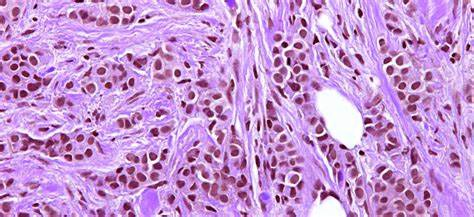

In [ ]:
cv2_imshow(img)

In [ ]:
img.shape

(217, 474, 3)

### **Metrics Function**

In [ ]:
from skimage.metrics import structural_similarity as ssim

def PSNR(original, normalized):
 mse = np.mean((original - normalized) ** 2)
 if(mse == 0):
  return 100
 max_pixel = 255.0
 psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
 return psnr 

def compare(imageA, imageB):
 # Calculate and SSIM
 s = ssim(imageA, imageB)

 # Return the SSIM. The higher the value, the more "similar" the two images are.
 return s

def structure_similarity(img_og, Inorm): 
 # Import images
 image1 = img_og
 image2 = Inorm

 # Convert the images to grayscale
 gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
 gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

 # Check for same size and ratio and report accordingly
 ho, wo, _ = image1.shape
 hc, wc, _ = image2.shape
 ratio_orig = ho/wo
 ratio_comp = hc/wc
 dim = (wc, hc)

 if round(ratio_orig, 2) != round(ratio_comp, 2):
  print("\nImages not of the same dimension. Check input.")
  exit()

 # Resize first image if the second image is smaller
 elif ho > hc and wo > wc:
  print("\nResizing original image for analysis...")
  gray1 = cv2.resize(gray1, dim)

 elif ho < hc and wo < wc:
  print("\nCompressed image has a larger dimension than the original. Check input.")
  exit()

 if round(ratio_orig, 2) == round(ratio_comp, 2):
  ssim_value = compare(gray1, gray2)
  print("SSIM:", ssim_value)
  value = PSNR(img_og, Inorm)
  print("\nPeak Signal-to-Noise Ratio (PSNR) value is", value, "dB")

### **NOrmalization Using SVD**

In [ ]:
def normalization(img):

  Io = 255 # Total light intensity (possible maximum) to calculate transmittance (I/Io) which helps further to calculate OD
  alpha = 1 # While finding angle between the first SVD directions and all the projected pixels, it will help to choose the maximum and minimum angle
  # for alpha percentile and 100-alpha percentile to avoid outliers and noise
  beta = 0.15 # OD threshold for transparent pixels

  # Standard Reference H&E OD Matrix, this is the matrix which will standardize the stain concentration of any image to the same
  HERef = np.array([[0.5626, 0.2159],
                    [0.7201, 0.8012],
                    [0.4062, 0.5581]])
  
  # Reference maximum stain concetrations for H&E, this will help to normalize the stain concentration
  maxCRef = np.array([1.9705, 1.0308])

  # Extracting the height, width and channel of the image
  h, w, c = img.shape
  img_og = img
  # Reshaping the image into multiple rows and 3 columns
  # Number of rows depends on the image size (h×w)
  img = img.reshape((-1, 3))

  # Calculate Optical Density
  # OD = -log(I)
  OD = -np.log10((img.astype(float)+1)/Io)

  # Standardizing image
  img = img/255

  # Plotting to see difference between OD and img
  fig = plt.figure(figsize = (20, 12))
  ax1 = fig.add_subplot(121, projection = '3d')
  ax2 = fig.add_subplot(122, projection = '3d')
  ax1.title.set_text('Non-Linear Relationship of Stain Concentrations and Stain Intensity')
  ax2.title.set_text('Linear Relationship of Stain Concentration and OD')

  for i in range(5000):
    ax1.scatter(img[i][0], img[i][1], img[i][2], color = (img[i][0], img[i][1], img[i][2]), s = 30, alpha = 0.5)
    ax2.scatter(OD[i][0], OD[i][1], OD[i][2], color = (img[i][0], img[i][1], img[i][2]), s = 30, alpha = 0.5)

  plt.show()

  ODhat = OD[~np.any(OD< beta, axis = 1)] # remove transparent pixels (clear region with no tissue)

  # Estimate covariance matrix of ODhat (transposed) and then eigne values and vectors are calculated
  # Using SVD, finding eigen vectors
  eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

  # Project on the plane spanned by the eigenvectors corresponding to the two largest eigen vectors corresponding to the largest eigen values
  That = ODhat.dot(eigvecs[:, 1:3]) # Dot product

  # Project data onto the plane and normalize to unit 
  # Calculate angle of each point wrt the first SVD direction
  # find the min and max vectors and project back to OD space
  phi = np.arctan2(That[:, 1], That[:, 0])
  minPhi = np.percentile(phi, alpha)
  maxPhi = np.percentile(phi, 100-alpha)

  vMin = eigvecs[:, 1:3].dot(np.array([np.cos(minPhi), np.sin(minPhi)]).T)
  vMax = eigvecs[:, 1:3].dot(np.array([np.cos(maxPhi), np.sin(maxPhi)]).T)

  # a heuristic to make the vector corresponding to hematoxylin and then corresponding to eosin second
  if vMin[0] > vMax[0]:
    HE = np.array((vMin, vMax)).T
  else:
    HE = np.array((vMax, vMax)).T

  # Comparing standard Stain vector with image stain vector
  # fig = plt.figure(figsize = (16, 8))
  # ax1 = fig.add_subplot(111, projection = '3d')

  # ax1.scatter(HERef[0, 0], HERef[1, 0], HERef[2, 0], color = "blue", s = 100, alpha = 0.5, marker = '*')
  # ax1.scatter(HE[0, 0], HE[1, 0], HE[2, 0], color = "blue", s = 100, alpha = 0.5)
  # ax1.scatter(HERef[0, 1], HERef[1, 1], HERef[2, 1], color = "pink", s = 100, alpha = 0.5, marker = '*')
  # ax1.scatter(HE[0, 0], HE[1, 0], HE[2, 0], color = "pink", s = 100, alpha = 0.5)

  # plt.show()

  # rows corresponds to channels RGB, columns to OD values
  Y = np.reshape(OD, (-1, 3)).T

  # determine concentrations of the individual stains i.e. HE * C = Y, then finding C
  C = np.linalg.lstsq(HE, Y, rcond = None)[0]

  # normalize stain concentrations
  maxC = np.array([np.percentile(C[0, :], 99), np.percentile(C[1, :], 99)])
  tmp = np.divide(maxC, maxCRef)
  C2 = np.divide(C, tmp[:, np.newaxis])

  # Convert extreme values back to OD Space and recreate the the normalized image using reference mixing matrix
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
  Inorm[Inorm>255] = 254
  Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

  # Separating the H & E components
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:, 0], axis = 1).dot(np.expand_dims(C2[0,:], axis = 0))))
  H[H>255] = 254
  H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

  E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:, 1], axis = 1).dot(np.expand_dims(C2[1,:], axis = 0))))
  E[E>255] = 254
  E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

  # Histogram of pixels
  histr = cv2.calcHist([img_og],[0],None,[256],[0,256])

  # Plotting Images
  figs = plt.figure(figsize = (20, 12) )
  figs.tight_layout()
  axs1 = figs.add_subplot(221)
  axs2 = figs.add_subplot(222)
  axs3 = figs.add_subplot(223)
  axs4 = figs.add_subplot(224)
  axs1.title.set_text('Original')
  axs2.title.set_text('Normalized')
  axs3.title.set_text('Hematoxylin')
  axs4.title.set_text('Eosin')
  axs1.imshow(img_og, aspect = "auto")
  axs2.imshow(Inorm, aspect = "auto")
  axs3.imshow(H, aspect = "auto")
  axs4.imshow(E, aspect = "auto")
  axs1.set_xticks([])
  axs1.set_yticks([])
  axs2.set_xticks([])
  axs2.set_yticks([])
  axs3.set_xticks([])
  axs3.set_yticks([])
  axs4.set_xticks([])
  axs4.set_yticks([])
  plt.show()

  print("Similarity Scores")
  structure_similarity(img_og, Inorm)

In [ ]:
# normalization(img)

In [ ]:
img = cv2.imread(r"/content/images/rough_images/SOB_M_DC-14-2773-400-001.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

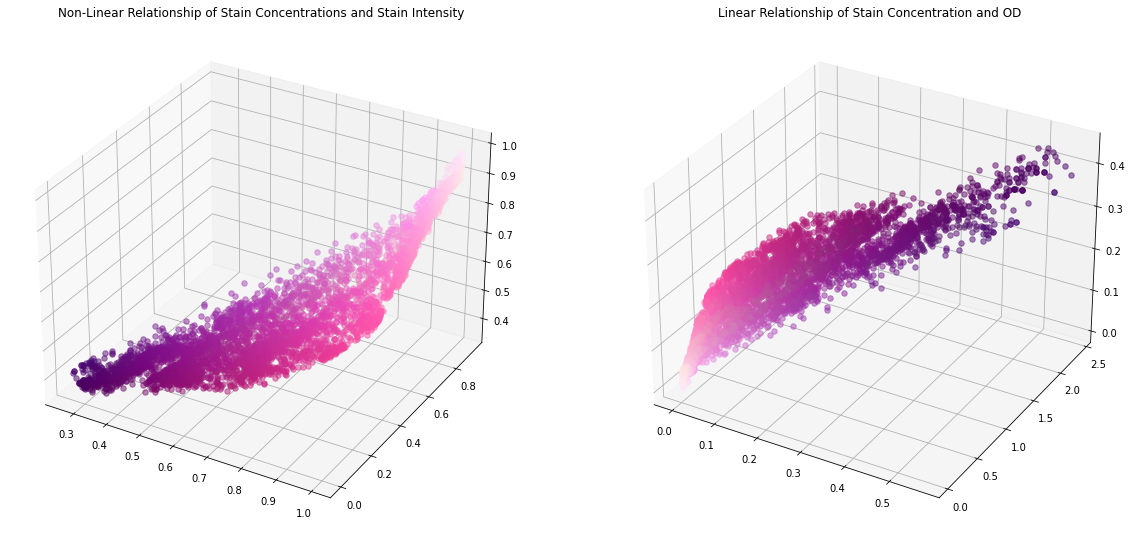

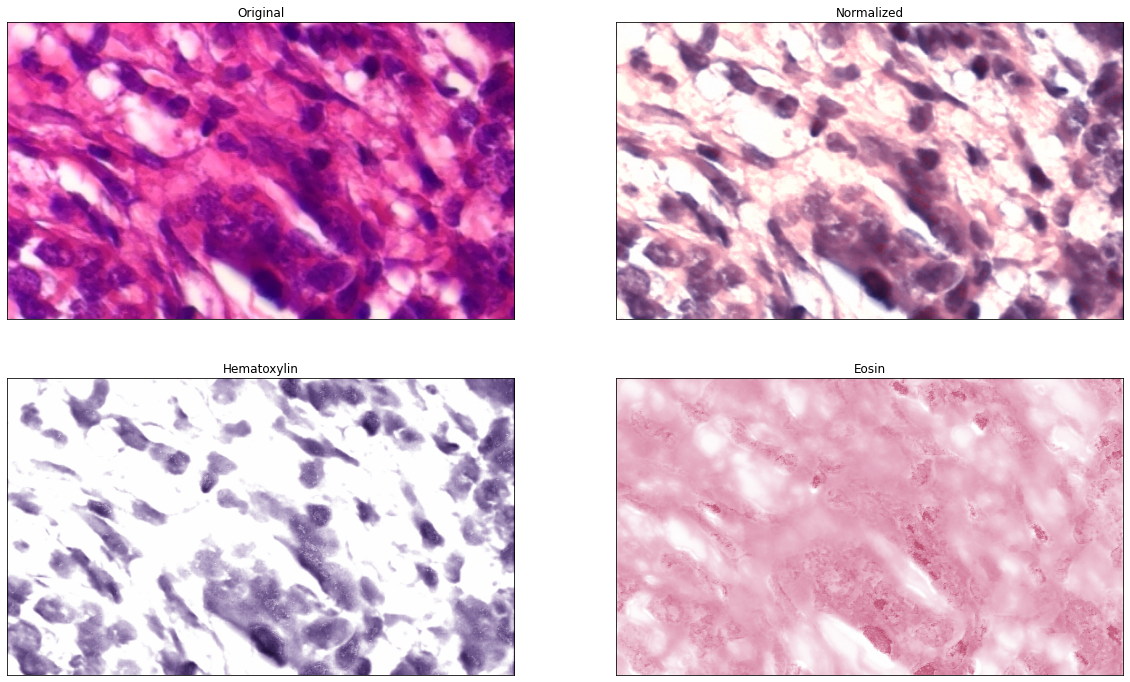

Similarity Scores
SSIM: 0.7502662987497304

Peak Signal-to-Noise Ratio (PSNR) value is 28.281364097125568 dB


In [ ]:
normalization(img)